# Classifier using Convolutional Neural Network

Classifier if a given image contains a horse or a human.

## Get Data

In [ ]:
# download data
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

--2020-12-31 05:17:24--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   126MB/s    in 1.1s    

2020-12-31 05:17:26 (126 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [ ]:
# unzip the data
import os
import zipfile
 
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

In [ ]:
# check the data
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
print('total training horse images:', len(os.listdir(train_horse_dir)))
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_dir = os.path.join('/tmp/horse-or-human/humans')
print('total training human images:', len(os.listdir(train_human_dir)))
train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

total training horse images: 500
['horse15-6.png', 'horse35-9.png', 'horse30-5.png', 'horse37-5.png', 'horse49-0.png', 'horse13-8.png', 'horse50-6.png', 'horse08-8.png', 'horse03-4.png', 'horse31-5.png']
total training human images: 527
['human11-04.png', 'human03-30.png', 'human06-20.png', 'human09-19.png', 'human11-01.png', 'human06-29.png', 'human09-16.png', 'human03-02.png', 'human17-26.png', 'human15-04.png']


## Explore the data

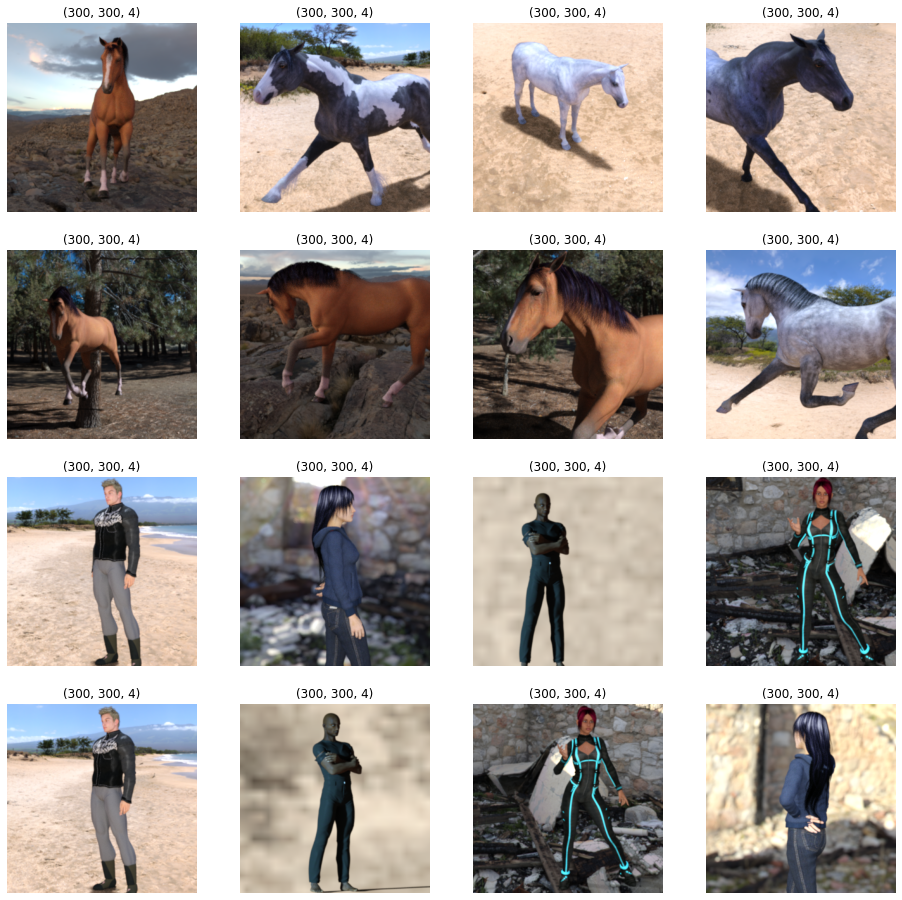

In [ ]:
# set image configuration as 4x4
nrows = 4
ncols = 4

# setup figure to fit 4x4 images
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

# display a batch of eight horse pictures and eight human pictures
import matplotlib.image as mpimg
next_horse_pix = [os.path.join(train_horse_dir, fname) for fname in train_horse_names[0:8]]
next_human_pix = [os.path.join(train_human_dir, fname) for fname in train_human_names[0:8]]
for i, img_path in enumerate(next_horse_pix + next_human_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.title(img.shape)
  plt.imshow(img)
plt.show()

## Create Model

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation: single output neuron => scalar 0 (horse) and 1 (human)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

## Compile the Model
* **Loss function**: *Binary Crossentropy* is used as it is a **binary classification**
* **Optimizer**: *RMSprop* optimization algorithm is preferable to *Stochastic Gradient Descent (SGD)* because it **automates learning-rate tuning for you**.
  * Other optimizers, such as *Adam* and *Adagrad*, also automatically adapt the learning rate during training and would work equally well here.

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    loss = 'binary_crossentropy', # binary classification
    metrics = ['acc'],
    optimizer = RMSprop(lr=0.001) # automatic learning rate tuning
)

## Preprocess the Data

### Data Generator

**Reads pictures** in the source folders, **convert them to float32 tensors**, and **feeds them with their labels to the network**.

Yields batches of images of size 300x300 and their binary labels.

### Normalization

It's uncommon to feed raw pixels into a CNN.

Normalize the original images with pixel values in range [0, 255] range to be in the [0, 1] range.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

X_trn_generator = datagen.flow_from_directory(
    '/tmp/horse-or-human',    # source directory for training images
    target_size = (300, 300), # images resized to (150 x 150)
    batch_size = 128,         # flow training images in batches of 128
    class_mode = 'binary'     # binary labels (for binary_crossentropy loss)
)

Found 1027 images belonging to 2 classes.


## Train the Model

The generators can then be used with the Keras model methods that accept data generators as inputs: *fit_generator*, *evaluate_generator* and *predict_generator*.

In [ ]:
history = model.fit(x=X_trn_generator, epochs=15, steps_per_epoch=8, verbose=1)

Epoch 1/15
8/8 [==============================] - 14s 703ms/step - loss: 4.2446 - acc: 0.4688
Epoch 2/15
8/8 [==============================] - 6s 790ms/step - loss: 0.6822 - acc: 0.5652
Epoch 3/15
8/8 [==============================] - 6s 793ms/step - loss: 0.7384 - acc: 0.5531
Epoch 4/15
8/8 [==============================] - 6s 677ms/step - loss: 0.6999 - acc: 0.6685
Epoch 5/15
8/8 [==============================] - 6s 680ms/step - loss: 0.4649 - acc: 0.7800
Epoch 6/15
8/8 [==============================] - 6s 688ms/step - loss: 0.5252 - acc: 0.7936
Epoch 7/15
8/8 [==============================] - 6s 688ms/step - loss: 0.2011 - acc: 0.9203
Epoch 8/15
8/8 [==============================] - 6s 681ms/step - loss: 0.3477 - acc: 0.8439
Epoch 9/15
8/8 [==============================] - 6s 683ms/step - loss: 0.9181 - acc: 0.8448
Epoch 10/15
8/8 [==============================] - 6s 687ms/step - loss: 0.0962 - acc: 0.9723
Epoch 11/15
8/8 [==============================] - 6s 777ms/step - l

## Test the Model

* Choose one or more files from your file system.
* Upload them.
* Run them through the model.
* Predict whether the object is a horse or a human.

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
for fkey in uploaded.keys():
  img = image.load_img('/content/'+fkey, target_size=(300, 300))
  x = image.img_to_array(img) # (150, 150, 3)
  x = np.expand_dims(x, axis=0)
  X_tst = np.vstack([x])
  y_pred = model.predict(x=X_tst, batch_size=10)
  if y_pred[0]>0.5:
    print(fkey + " is a human")
  else:
    print(fkey + " is a horse")

Saving horse3.jpeg to horse3.jpeg
horse3.jpeg is a horse


## Note

### Overfitting

* The network makes a lot of mistakes despite the fact that the training accuracy is above 97%.
* The neural network is **trained with very limited data**. 
* It is **very good at recognizing images that look like those in the training set, but it can fail a lot at images that are not in the training set**.
* That's a datapoint proving that **the more data that you train on, the better your final network will be**!

## Visualize Image Transformations

To visualize the feature learning by the CNN through the intermediate representations.

* Pick a random image from the training set.
* Generate a figure.
  * Each row is the output of a layer.
  * Each image in the row is a specific filter in that output feature map.
* Generate the intermediate representations for the image.

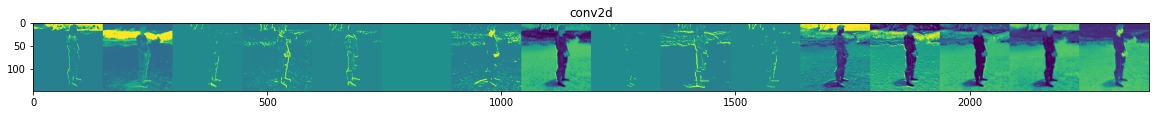

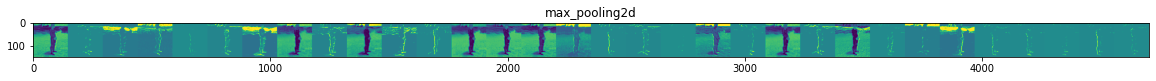

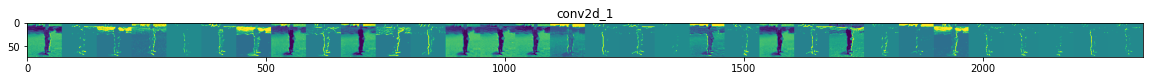

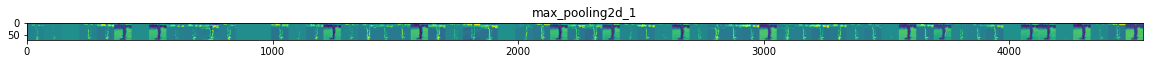

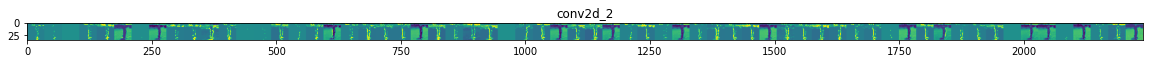

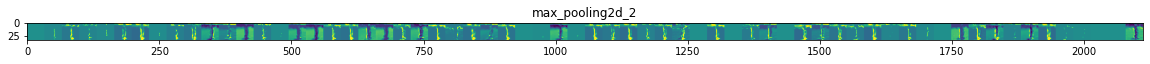

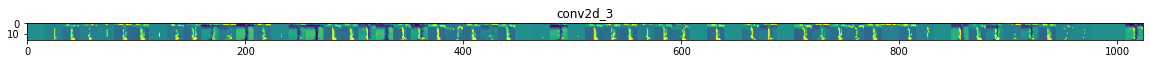

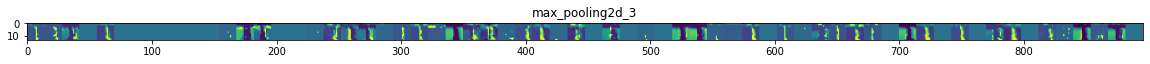

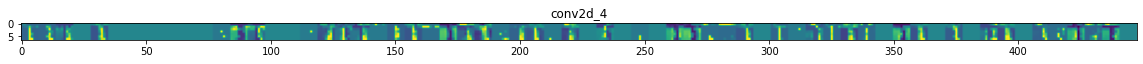

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# The intermediate outputs for all the layers of the model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
layer_names = [layer.name for layer in model.layers]

# The visualization model
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

# Pick a random input image from the training set
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)
img = load_img(img_path, target_size=(300, 300))  # this is a PIL image

# Generate a figure from the randomly picked image
x = img_to_array(img)  # (150, 150, 3)
x = x.reshape((1,) + x.shape)  # (1, 150, 150, 3)
x /= 255 # rescale

# Produce the intermediate representations for this image by running through the network
successive_feature_maps = visualization_model.predict(x)

# Display the representations just do for the conv / maxpool layers
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  # Only for conv / maxpool layers
  if len(feature_map.shape) == 4:
    
    n_features = feature_map.shape[-1]  # number of features in feature map
    size = feature_map.shape[1] # feature map has shape (1, size, size, n_features)
    display_grid = np.zeros((size, size * n_features))
    
    for i in range(n_features):
      
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      if x.std()>0:
        x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')

      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Conclusion

### Representation Sparsity

* We go **from the raw pixels** of the images to increasingly **abstract and compact representations**.
* The representations downstream **start highlighting what the network pays attention to**, and they **show fewer and fewer features being "activated."** Most are set to zero.
* Those representations **carry increasingly less information about the original pixels of the image**, but **increasingly refined information about the class of the image**. 
* Key feature of Deep Learning: **information distillation pipeline**.
